## Dependencies

In [1]:
import os.path as osp
import glob
import cv2
import numpy as np
import torch
import ESRGAN.RRDBNet_arch as arch # Make sure you clone the ESRGAN repository
import os
from ipywidgets import FileUpload
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

model_path = os.path.join(os.getcwd(),'ESRGAN','models','RRDB_ESRGAN_x4.pth') # change this if incorrect
print(model_path)

c:\Projects\python\image-video-super-resolution\ESRGAN\models\RRDB_ESRGAN_x4.pth


## Device setup

In [2]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    current_device= torch.cuda.current_device()
    # Limit memory usage to 80%
    torch.cuda.set_per_process_memory_fraction(0.8,device=current_device)
    # For optimized memory utilization during tensor operations
    torch.backends.cudnn.benchmark = True
    print(f"Using Device: {device}",
          f"\nCurrent GPU: {torch.cuda.get_device_name(current_device)}",
          f"\nCuda version: {torch.version.cuda}",
          f"\ncuDNN available: {torch.backends.cudnn.is_available()}",
          f"\ncuDNN version: {torch.backends.cudnn.version()}",
          f"\nAllocated memory: {torch.cuda.memory_allocated()} bytes",
          f"\nCached memory: {torch.cuda.memory_reserved()} bytes")
else:
    device = torch.device("cpu")
    print(f"Using Device: {device}")

Using Device: cuda 
Current GPU: NVIDIA GeForce RTX 4060 Laptop GPU 
Cuda version: 11.8 
cuDNN available: True 
cuDNN version: 90100 
Allocated memory: 0 bytes 
Cached memory: 0 bytes


In [3]:
# load the model
# model = arch.RRDBNet(in_nc=3,out_nc=3, nf=64,nb=23,gc=32)
model = arch.RRDBNet(in_nc=3,out_nc=3, nf=64,nb=23,gc=32)
model.load_state_dict(torch.load(model_path),strict=True)
model.eval()
model = model.to(device=device)

C:\Users\harsh\AppData\Local\Temp\ipykernel_7748\2925550005.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path),strict=True)


## Main

In [4]:
def super_resolution(model,uploaded_images,device):
    os.makedirs(os.path.join(os.getcwd(),'outputs'),exist_ok=True)
    fig, axes = plt.subplots(len(uploaded_images),2,figsize=(10,5*len(uploaded_images)))
    if len(uploaded_images)==1:
        axes=[axes]
    
    for idx, file_obj in enumerate(uploaded_images):

        # Load the original image
        name = file_obj.name
        img = Image.open(BytesIO(file_obj.content)).convert('RGB')
        # img = img.resize((500,480),Image.LANCZOS)
        img_np = np.array(img) / 255.0  # Normalize to [0, 1]

        # Prepare the image for the model
        img_tensor = torch.from_numpy(np.transpose(img_np[:, :, [2, 1, 0]], (2, 0, 1))).float()
        img_LR = img_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_LR).data.squeeze().float().cpu().clamp_(0,1).numpy()

        # convert the output back to numpy format
        output_img = np.transpose(output[[2,1,0],:,:],(1,2,0))
        output_img = (output_img*255.0).astype(np.uint8)
        # output_img = cv2.resize(output_img,(img_width,img_height))

        # save the output
        base_name = os.path.splitext(os.path.basename(name))[0]
        output_path = os.path.join(os.getcwd(),'outputs',f"{base_name}_sr.jpg")
        os.makedirs(os.path.dirname(output_path),exist_ok=True)
        cv2.imwrite(output_path,cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR))
        
        # plot the original and super-resolution images
        axes[idx][0].imshow(img)
        axes[idx][0].set_title(f'Original {base_name}')
        axes[idx][0].axis('off')

        axes[idx][1].imshow(output_img)
        axes[idx][1].set_title(f'Super resolution {base_name}')
        axes[idx][1].axis('off')
        
    plt.tight_layout()
    plt.show()   

In [6]:
uploader = FileUpload(accept='image/*', multiple=True)
display(uploader)


FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

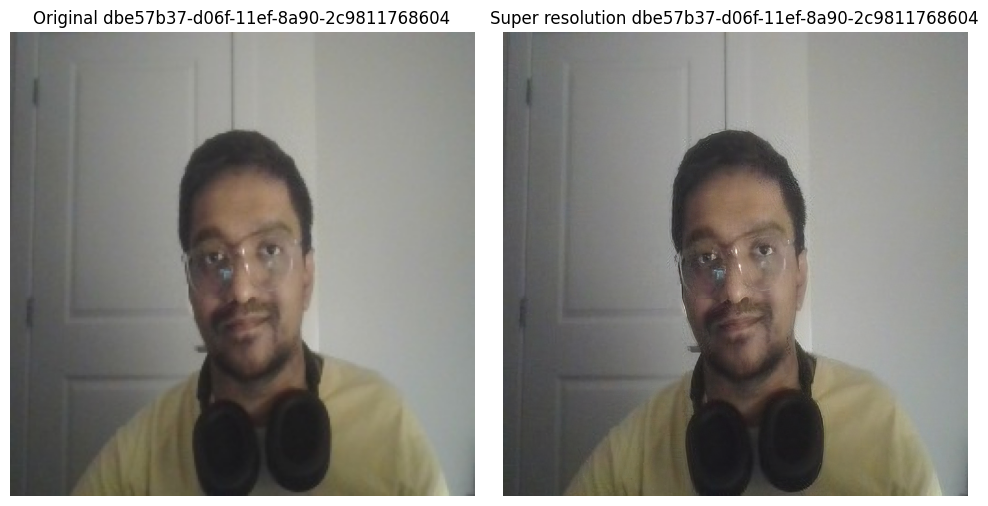

In [11]:
if uploader.value:
    super_resolution(model=model,uploaded_images=uploader.value,device=device)
else:
    print('No Images Selected')

## Degrade images

In [8]:
# os.getcwd()

In [9]:
# from PIL import Image

# def reduce_image_quality(input_image_path, output_image_path, new_resolution, quality):
#     # Open an image file
#     with Image.open(input_image_path) as img:
#         # Resize image
#         img = img.resize(new_resolution, Image.LANCZOS)
        
#         # Save it as a JPEG file with the specified quality
#         img.save(output_image_path, format='JPEG', quality=quality)
# # 
# # Example usage
# input_image_path = os.path.join(os.getcwd(),'inputs','56171023-cfae-11ef-84e9-2c9811768604.jpg')
# output_image_path = os.path.join(os.getcwd(),'inputs','harshal1.jpg')
# os.makedirs(os.path.dirname(output_image_path),exist_ok=True)
# new_resolution = (500, 500)  # new resolution (width, height)
# quality = 20  # Quality level from 1 (worst) to 95 (best)

# reduce_image_quality(input_image_path, output_image_path, new_resolution, quality)
